In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [20, 10]

In [2]:
global_path = "/home/julia/Desktop/DIP/lab3"
file_name = "cat"

In [3]:
def plot_array_of_images(values, path_to_write, f):
    fig, axes = plt.subplots(1, len(values))
    for i, value in enumerate(values):
        binary = f(value)
        axes[i].imshow(binary, cmap='gray')
        axes[i].set_title(f"{value}")
        axes[i].set_axis_off()
        cv2.imwrite(f"{global_path}/{path_to_write}/cat_{value}.png", binary)
plt.show()

In [4]:
class ImageAnalyser:
    def __init__(self, path_to_img):
        self.path_to_img = path_to_img
        self.colored_img = self.read()
        # needed as opencv read image in BGR format
        self.convert_from_bgr_to_rgb()
        self.gray_img = self.convert_img_to_gray().astype(np.uint8)

    # read image by path
    def read(self) -> np.ndarray:
        return cv2.imread(self.path_to_img)
    
    def convert_from_bgr_to_rgb(self):
        b, g, r = self.colored_img[:, :, 0], self.colored_img[:, :, 1], self.colored_img[:, :, 2]
        
        rgb_img = np.zeros_like(self.colored_img)
        rgb_img[:, :, 0] = r
        rgb_img[:, :, 1] = g
        rgb_img[:, :, 2] = b
        
        self.colored_img = rgb_img
        
    def convert_from_rgb_to_bgr(self):
        r, g, b = self.colored_img[:, :, 0], self.colored_img[:, :, 1], self.colored_img[:, :, 2]
        
        bgr_img = np.zeros_like(self.colored_img)
        bgr_img[:, :, 0] = b
        bgr_img[:, :, 1] = g
        bgr_img[:, :, 2] = r
        
        return bgr_img
        
    # converts image to grayscale
    def convert_img_to_gray(self) -> np.ndarray:
        r, g, b = self.colored_img[:, :, 0], self.colored_img[:, :, 1], self.colored_img[:, :, 2]
        gray_img = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray_img
    
    def create_hist(self, path_to_save):
        red_dict = {}
        green_dict = {}
        blue_dict = {}
        for i in range(0, 256):
            red_dict[i] = len(np.where(self.colored_img[:, :, 0] == i)[0])
            green_dict[i] = len(np.where(self.colored_img[:, :, 1] == i)[0])
            blue_dict[i] = len(np.where(self.colored_img[:, :, 2] == i)[0])
            
        fig, axes = plt.subplots(1, 3)
        axes[0].bar(red_dict.keys(), red_dict.values(), 1, color='red')
        axes[1].bar(green_dict.keys(), green_dict.values(), 1, color='green')
        axes[2].bar(blue_dict.keys(), blue_dict.values(), 1, color='blue')
        plt.savefig(f"{path_to_save}/hist.png")

        plt.show()
        
    def log(self, c):
        out_img = self.colored_img.astype(float)
        out_img = c * np.log(out_img + 1)
        return out_img.astype(np.uint8)
    
    def gamma_corr(self, gamma, c=1):
        out_img = self.colored_img.astype(float)
        out_img = c * np.power(out_img / 255, gamma)
        out_img *= 255
        return out_img.astype(np.uint8)
    
    def piecewise_linear(self):
        pass

image_analyser = ImageAnalyser(f"{global_path}/{file_name}.jpg")

### 1
Create hist of image

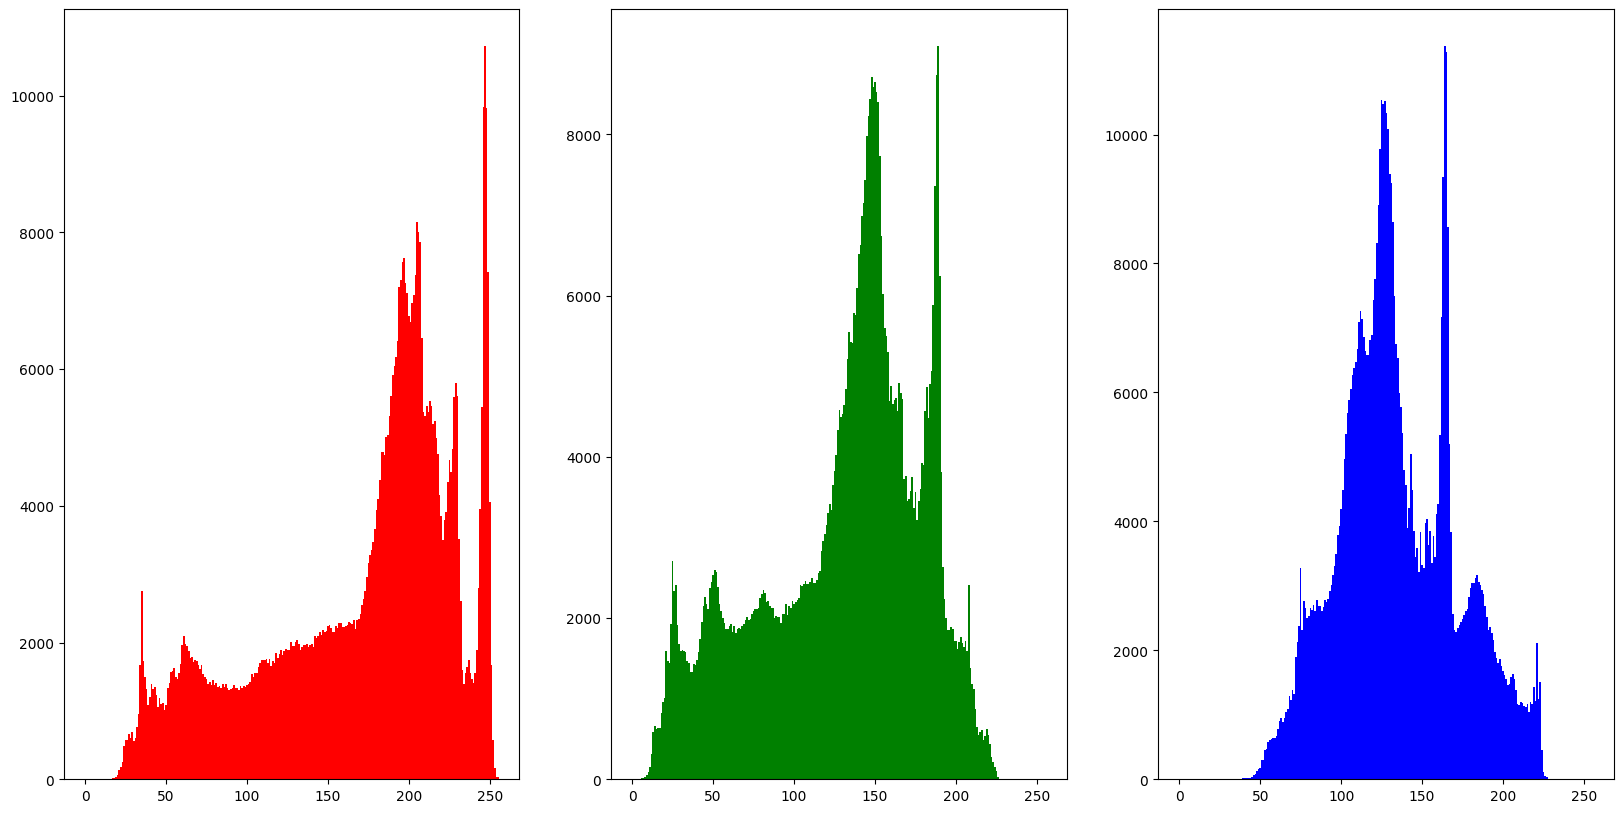

In [5]:
image_analyser.create_hist("/home/julia/Desktop/DIP/lab3")

### 2
Log image

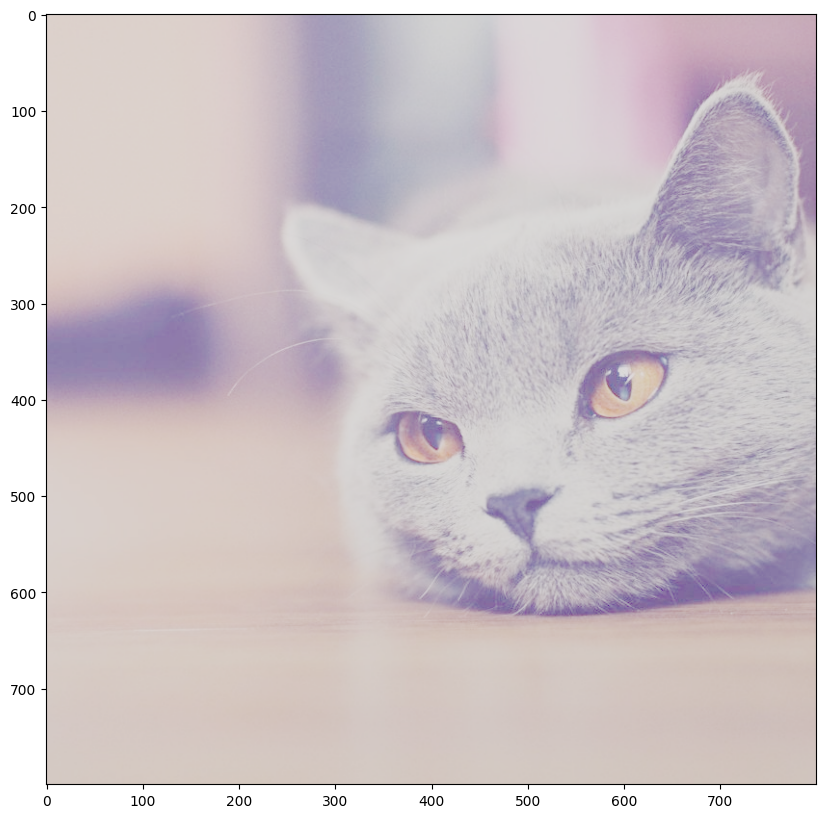

In [6]:
log_img = image_analyser.log(40)

plt.imshow(log_img)
plt.show()

### 3
Gamma correction

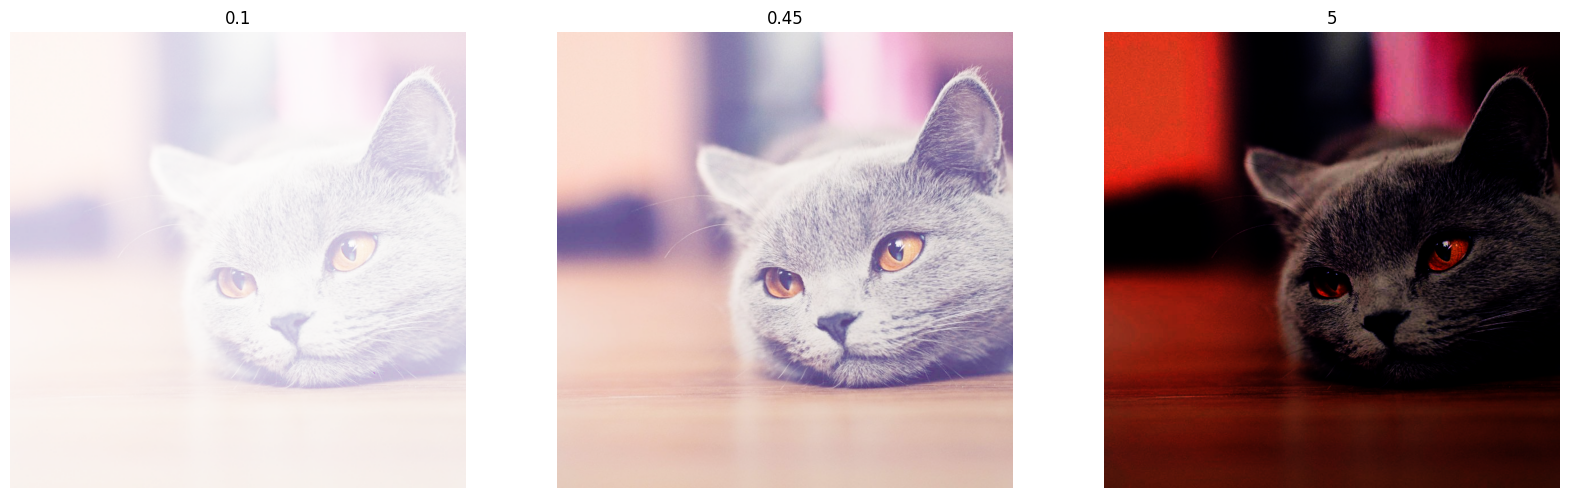

In [9]:
gammas = [0.1, 0.45, 5]

plot_array_of_images(gammas, f"{global_path}/Degree", image_analyser.gamma_corr)